In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import models
import numpy as np
import os.path as op
import pymc as pm
import seaborn as sns

sns.set_context('notebook')
sns.set_palette('colorblind')

outdir = op.join('..', 'data')

Here is our observation model, this time un-tethered to redshift measurements:

In [3]:
dmax = 1.0

def draw_Al_Ar(x, d):
    Ar = np.random.normal(loc=np.square(1+x)/d, scale=1)
    Al = np.random.normal(loc=np.square(1-x)/d, scale=1)

    return (Al, Ar)

def draw_observation(snr=None):
    x = np.random.uniform(low=-1, high=1)

    if snr is None:
        V = np.random.uniform(low=0, high=dmax*dmax*dmax)
        d = np.cbrt(V)
    else:
        Al1 = np.square(1-x)
        Ar1 = np.square(1+x)

        rho1 = np.sqrt(0.5*(Al1*Al1 + Ar1*Ar1))
        d = rho1/snr

    Al_obs, Ar_obs = draw_Al_Ar(x, d)
    
    return (x, d, Ar_obs, Al_obs)

In [35]:
# Like GW170817
x = -0.99
d = np.square(1-x)/30

print(f'x = {x}, d = {d}')

Al, Ar = draw_Al_Ar(x, d)
model = models.make_basic_pe_model(Al, Ar, dmax=dmax)
with model:
    thin = 4
    trace = pm.sample(tune=thin*1000, draws=thin*1000, init='jitter+adapt_full', target_accept=0.99)

x = -0.99, d = 0.13200333333333333


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/wfarr/miniconda3/envs/BrightSirenInclinationSystematics/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:629: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, V]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 6 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int64 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [36]:
az.ess(trace)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.619e+03
    V        float64 2.211e+03
    d        float64 2.211e+03
    Al       float64 7.405e+03
    Ar       float64 1.613e+03

array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>],
       [<Axes: title={'center': 'V'}>, <Axes: title={'center': 'V'}>],
       [<Axes: title={'center': 'd'}>, <Axes: title={'center': 'd'}>],
       [<Axes: title={'center': 'Al'}>, <Axes: title={'center': 'Al'}>],
       [<Axes: title={'center': 'Ar'}>, <Axes: title={'center': 'Ar'}>]],
      dtype=object)

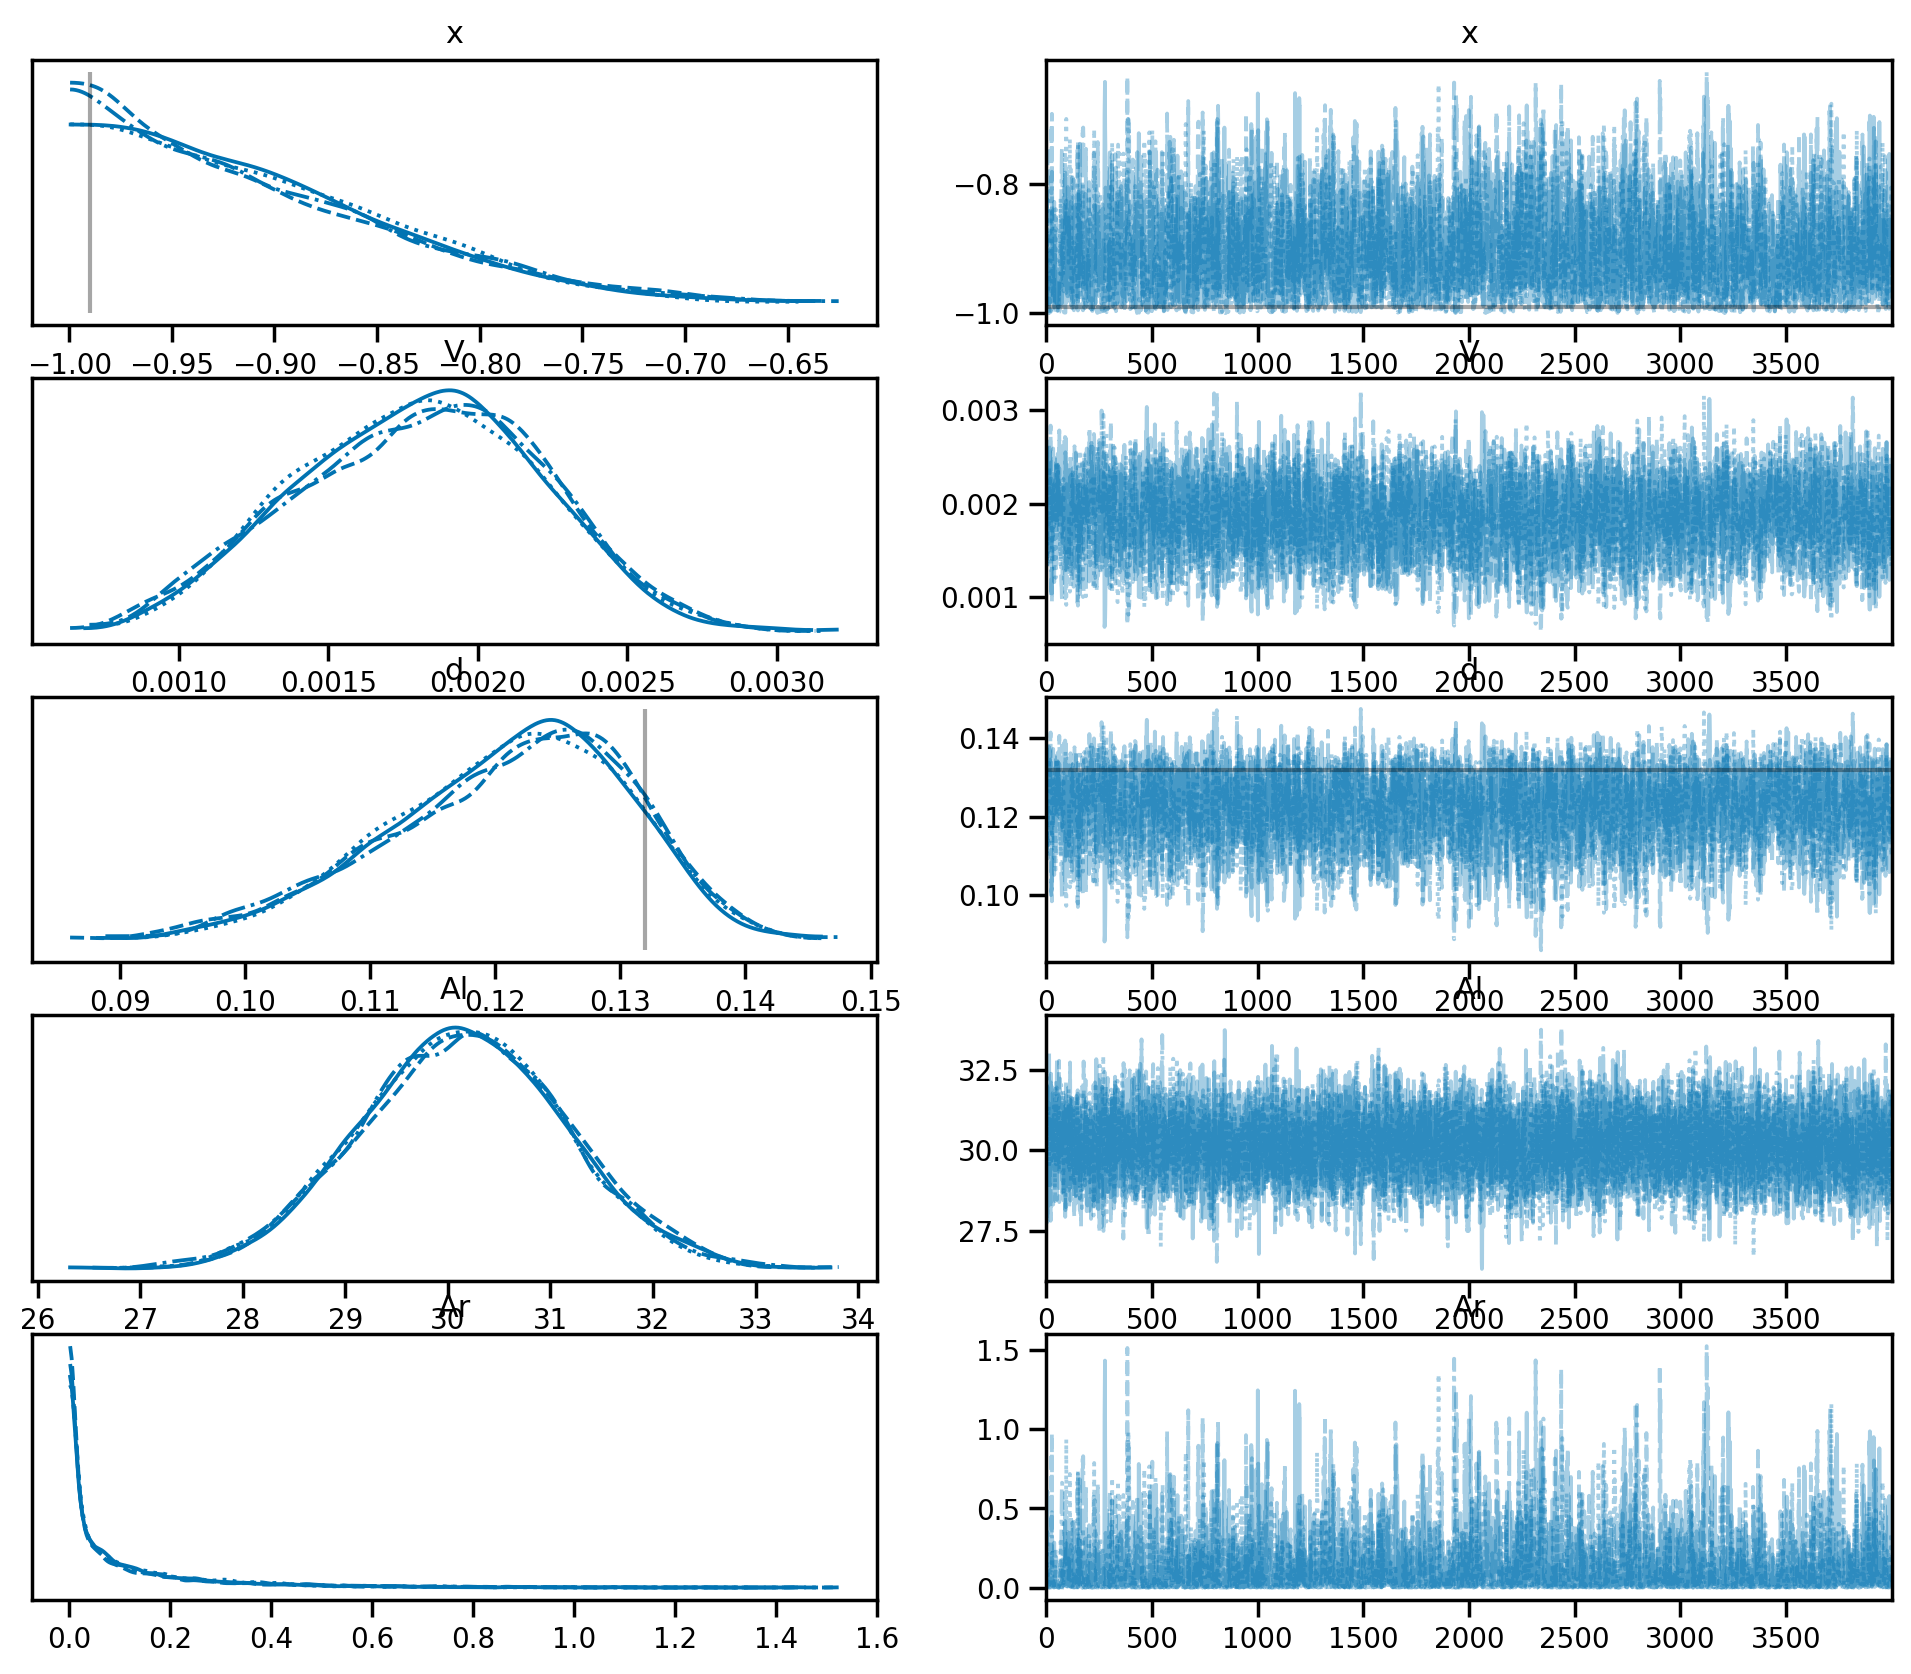

In [37]:
az.plot_trace(trace, lines=[('x', {}, x), ('d', {}, d)])

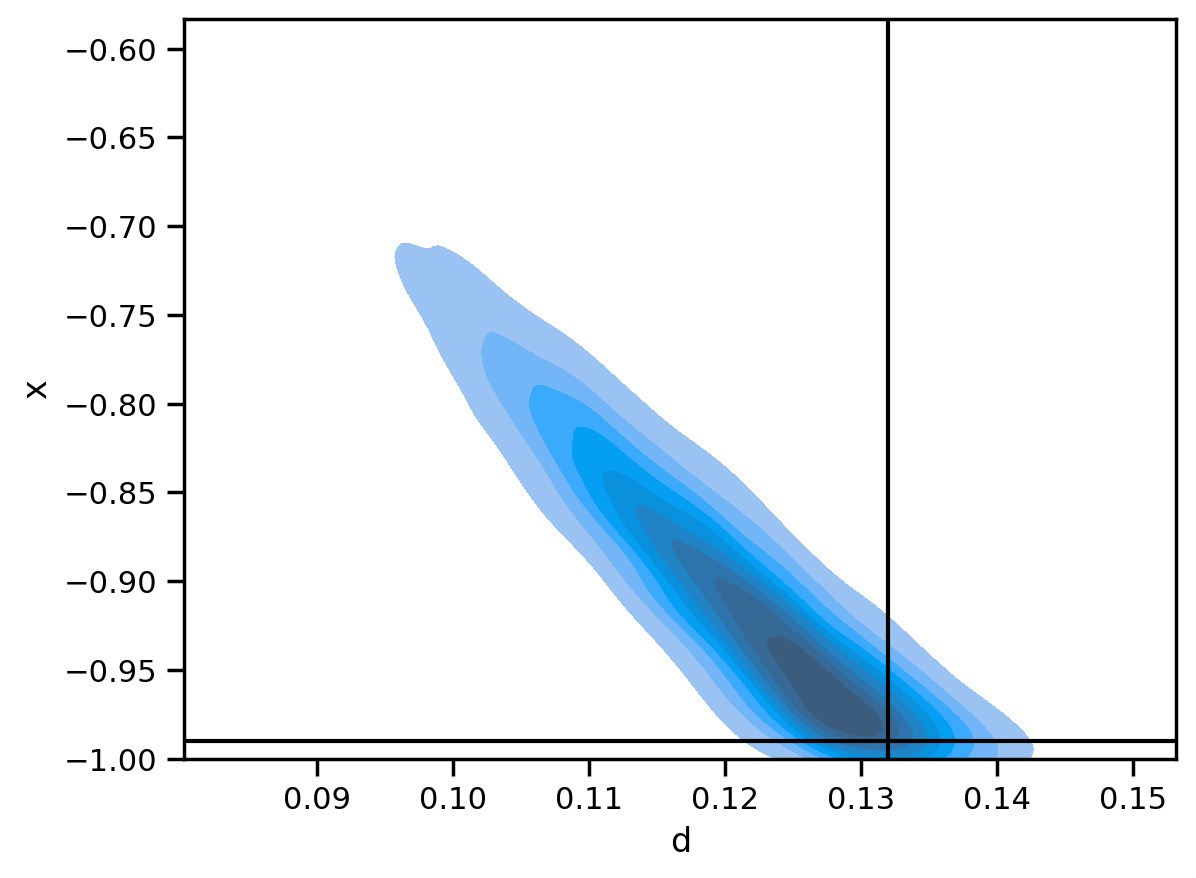

In [40]:
sns.kdeplot(data=az.extract(trace.posterior), x='d', y='x', fill=True)
plt.ylim(bottom=-1)
plt.axhline(x, color='k')
plt.axvline(d, color='k')

In [41]:
az.to_netcdf(trace, op.join(outdir, 'GW170817-like-chain.nc'))

'../data/GW170817-like-chain.nc'

Fractional uncertainty on $d$:

In [42]:
d = trace.posterior.d
d.std() / d.mean()

<xarray.DataArray 'd' ()>
array(0.078162)

What about the maximum $x$?

In [43]:
trace.posterior.x.quantile(0.84)

<xarray.DataArray 'x' ()>
array(-0.83549802)
Coordinates:
    quantile  float64 0.84